In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


use_cuda=True
batch_size_train = 200
batch_size_test = 1
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import scipy.stats as stats

def psnr(x, x_test):
  mse = np.mean((np.reshape(x_test,[32,32])-np.reshape(x,[32,32]))**2)
  psnr = -100.0*np.log10(mse)
  return psnr

def entropy(x):
  return stats.entropy(x.flatten())

In [3]:
from torch.utils.data import random_split
#Give your own appropriate path if necessary
MNIST_training = torchvision.datasets.MNIST('/content/drive/My Drive/data/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(padding=2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test_set = torchvision.datasets.MNIST('/content/drive/My Drive/data/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Pad(padding=2),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])

train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 8302707.86it/s]                            


Extracting /content/drive/My Drive/data/MNIST_dataset/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/My Drive/data/MNIST_dataset/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 133048.36it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/My Drive/data/MNIST_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/My Drive/data/MNIST_dataset/MNIST/raw


1654784it [00:00, 2206192.81it/s]                            
0it [00:00, ?it/s]

Extracting /content/drive/My Drive/data/MNIST_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/My Drive/data/MNIST_dataset/MNIST/raw


8192it [00:00, 49065.64it/s]            


Extracting /content/drive/My Drive/data/MNIST_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/My Drive/data/MNIST_dataset/MNIST/raw
Processing...
Done!


In [4]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
            

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model from google drive
#model.load_state_dict(torch.load('/content/drive/My Drive/data/MNIST_LeNet_results/model.pth'))
# OR Load the pretrained model directly if you upload the model inside Files
model.load_state_dict(torch.load('/content/drive/My Drive/model.pth'))
#model.eval()

CUDA Available:  True


<All keys matched successfully>

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad
  # Adding clipping to maintain [0,1] range
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  # Return the perturbed image
  return perturbed_image

result:
Student Name= Ziming Fu, Student id: 1370023
question 1:	entropy=6.661957740783691	max_prob=0.8032339215278625	score=1.0
question 2:	psnr=33.30639898777008		label=0		score=1.0
total_score=1.0
assignment_coding_score=75.00, out of 75.00


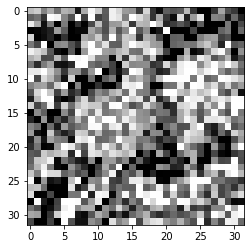

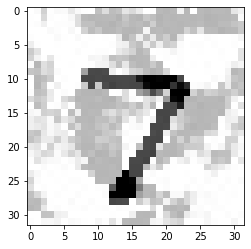

In [6]:
import matplotlib.pyplot
import cv2

def main():
  
  entropy_min_thres1 = 6.0
  prob_min_thres1 = 0.7
  prob_max_thres1 = 0.8
  
  fake_label2 = 0
  psnr_min_thres2 = 25
  psnr_max_thres2 = 28
  
  image1 = matplotlib.pyplot.imread('/content/drive/My Drive/image1.jpg')
  # image2 = matplotlib.pyplot.imread('/content/drive/My Drive/image2.jpg')
  image1 = image1.reshape((1, 1, 32, 32)) / 255.0
  # image2 = image2.reshape((1, 1, 32, 32)) / 255.0
  tensor1 = torch.tensor(image1, dtype=torch.float32).to(device)
  # tensor2 = torch.tensor(image2, dtype=torch.float32).to(device)
 
  images = []
  
  # score 1st question

  # Perform target attack on tnesor1
  tensor1.requires_grad = True
  target = 1
  cost = 0
  epsilon = 0.001
  # Do iterations on fgsm attack call to move the image tensor with small epsilon, thus fool the nn incrementally.
  # For this question, a cost must >= 0.8
  while cost < 0.8:
    #print(cost)
    output = model(tensor1)
    tensor1.retain_grad()
    output_onehot = torch.exp(output)
    cost = output_onehot[0][target].item()
    output_onehot[0][target].backward(retain_graph=True)
    data_grad = tensor1.grad
    # Call fgsm attack
    tensor1 = fgsm_attack(tensor1, epsilon, data_grad)

  # Save .npy file 
  np_image_new_1= tensor1.cpu().detach().numpy()
  np.save('/content/drive/My Drive/image_new_1.npy', np_image_new_1)

  # Tensor to image
  image_new_1 = tensor1.data.cpu().numpy()
  image_new_1 = image_new_1[0][0]
  cv2.imwrite('/content/drive/My Drive/image_new_1.jpg',image_new_1*255)
  imagenew1 = matplotlib.pyplot.imread('/content/drive/My Drive/image_new_1.jpg')
  images.append(imagenew1)

  output = torch.exp(model(tensor1))
  output_np = output.detach().cpu().numpy()
  max_prob1 = np.amax(output_np)
  entropy1 = entropy(image_new_1)
  score1 = (max_prob1 - prob_min_thres1) / (prob_max_thres1 - prob_min_thres1)
  score1 = np.clip(score1, 0, 1)
  score1 = score1 if entropy1 > entropy_min_thres1 else 0
  
 
    
  # score 2nd question
  for xb, yb in test_loader:
    break #just once
  test_data= xb.cpu().numpy()
 
  # Send the tensor data to the device
  data = xb.to(device)
  # Set requires_grad attribute of tensor. Important for Attack
  data.requires_grad = True

  # Forward pass the data through the model
  # output = model(data)
  # init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
  # print('The initia prediction of label for very first data of test loader is\t%d.' % (init_pred))

  # Perform target attack
  target = 0
  cost = 0
  epsilon = 0.001
  # Do iterations on fgsm attack call to move the image tensor with small epsilon, thus fool the nn incrementally.
  # For this question, a cost >=0.5 on onehottensor[0] can guarantee the label to be [0]
  while cost < 0.5:
    output = model(data)
    data.retain_grad()
    output_onehot = torch.exp(output)
    cost = output_onehot[0][target].item()
    output_onehot[0][target].backward(retain_graph=True)
    data_grad = data.grad
    # Call fgsm attack
    data = fgsm_attack(data, epsilon, data_grad)

  # Save .npy file 
  np_image_new_2= data.cpu().detach().numpy()
  np.save('/content/drive/My Drive/image_new_2.npy', np_image_new_2)

  # Tensor to image
  image_new_2 = data.data.cpu().numpy()
  image_new_2 = image_new_2[0][0]
  cv2.imwrite('/content/drive/My Drive/image_new_2.jpg',image_new_2*255)
  imagenew2 = matplotlib.pyplot.imread('/content/drive/My Drive/image_new_2.jpg')
  images.append(imagenew2)

  # Plot the images to figure
  for i in images:
    plt.figure()
    plt.imshow(i, cmap='gray_r')

  # retrieve the result label of image after iterative fgsm attack
  per_output = model(data)
  per_pred = per_output.max(1, keepdim=True)[1]
  label2 = per_pred.item()
  
  #print(xb.shape, image2.shape)
  data= data.cpu().detach().numpy()
  psnr2 = psnr(test_data, data)
  score2 = (psnr2 - psnr_min_thres2) / (psnr_max_thres2 - psnr_min_thres2)
  score2 = np.clip(score2, 0, 1)
  score2 = score2 if label2 == fake_label2 else 0


  total_score = score1 * 0.5 + score2 * 0.5
  assignment_score = total_score * 75
    
  result = (f"Student Name= Ziming Fu, Student id: 1370023\n"
            f"question 1:\tentropy={entropy1}\tmax_prob={max_prob1}\tscore={score1}\n"
            f"question 2:\tpsnr={psnr2}\t\tlabel={label2}\t\tscore={score2}\n"
            f"total_score={total_score}\n"
            f"assignment_coding_score={assignment_score:.2f}, out of 75.00")
  print("result:")
  print(result)
  
  with open('/content/drive/My Drive/result.txt', 'w') as f:
    f.writelines(result)

main()